<a href="https://colab.research.google.com/github/Ayesha-Noor-8874/Airbnb-Host-Analysis/blob/main/AirBNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📚Add the Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 📂 DataLoader Class

The **DataLoader** class handles all dataset loading and preprocessing steps.  
It ensures that the Airbnb dataset is cleaned, standardized, and ready for analysis.

---

## 🔍 **Key Responsibilities**
- Load the Airbnb dataset  
- Display basic dataset information  
- Remove duplicate rows  
- Handle missing values (numeric + categorical)  
- Standardize inconsistent column names  
- Convert price and percentage columns to numeric format  
- Detect price outliers using IQR  
- Create additional derived features  
- Create host performance scoring metric  

---

## 🧩 **Available Methods**

### **1. `__init__(file_path)`**
Initializes the class with the file path.

### **2. `load_data()`**
- Loads the CSV file.
- Handles bad lines and low-memory issues.
- Displays dataset shape.

### **3. `show_basic_info()`**
Prints:
- Dataset info  
- First 5 rows  
- Missing value counts  

### **4. `remove_duplicates()`**
Removes all duplicate rows and reports how many were removed.

### **5. `handle_missing_values()`**
- Numeric columns → filled with **median**  
- Categorical columns → filled with **mode**  
- Prints updated missing values summary  

### **6. `standardize_column_names()`**
- Converts all column names → lowercase & underscores  
- Fixes naming inconsistencies such as:  
  - `review_rate_number` → `review_scores_value`

### **7. `convert_columns()`**
Cleans and converts:
- **price** → float (removes `$`, `,`)  
- **host_response_rate** → float (removes `%`)  
- **host_acceptance_rate** → float (removes `%`)  

### **8. `detect_price_outliers()`**
Identifies outliers in `price` column using the IQR method.

### **9. `create_derived_features()`**
Creates:
- `occupancy_rate` = 365 − availability_365  
- `estimated_revenue` = price × occupancy_rate  

### **10. `create_host_score()`**
Weighted score based on:
- 50% review score  
- 30% host response rate  
- 20% acceptance rate  

---


In [42]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
    def load_data(self):
        """Loads CSV dataset."""
        self.df = pd.read_csv(self.file_path, on_bad_lines='skip', low_memory=False)
        print("📌 Dataset loaded successfully!")
        print("Shape:", self.df.shape)
        return self.df
#basic info
    def show_basic_info(self):
        print("\n===== BASIC INFO =====")
        print(self.df.info())
        print("\n===== FIRST 5 ROWS =====")
        print(self.df.head())
        print("\n===== MISSING VALUES =====")
        print(self.df.isnull().sum())
    #remove Duplicates
    def remove_duplicates(self):
        """Removes duplicate rows."""
        before = self.df.shape[0]
        self.df.drop_duplicates(inplace=True)
        after = self.df.shape[0]
        print(f"\n Removed {before - after} duplicate rows.")
        return self.df
#handle missing values
    def handle_missing_values(self):
        """Handles missing numeric & categorical values."""
        numeric = self.df.select_dtypes(include=['float64', 'int64']).columns
        categorical = self.df.select_dtypes(include=['object']).columns

        # Numeric → median
        self.df[numeric] = self.df[numeric].fillna(self.df[numeric].median())
        # Categorical → mode
        self.df[categorical] = self.df[categorical].fillna(self.df[categorical].mode().iloc[0])

        print("\n📌 Missing values handled.")
        print(self.df.isnull().sum())
        return self.df
    # Standardize column names
    def standardize_column_names(self):
        """Standardizes column names to be lowercase and use underscores."""
        self.df.columns = self.df.columns.str.lower().str.replace(' ', '_')
        # Specific renames for consistency with HostAnalysis class
        if 'review_rate_number' in self.df.columns:
            self.df.rename(columns={'review_rate_number': 'review_scores_value'}, inplace=True)
        print("\n📌 Column names standardized.")
        print(self.df.columns.tolist())
        return self.df
      #Covert DataTypes
    def convert_columns(self):
        """Convert price & percentages if they exist."""
        if "price" in self.df.columns:
            self.df["price"] = (
                self.df["price"]
                .astype(str)
                .str.replace("$", "", regex=False)
                .str.replace(",", "", regex=False)
                .astype(float)
            )
        if "host_response_rate" in self.df.columns:
            self.df["host_response_rate"] = (
                self.df["host_response_rate"]
                .astype(str)
                .str.replace("%", "", regex=False)
                .astype(float)
            )
        if "host_acceptance_rate" in self.df.columns:
            self.df["host_acceptance_rate"] = (
                self.df["host_acceptance_rate"]
                .astype(str)
                .str.replace("%", "", regex=False)
                .astype(float)
            )
        print("\n📌 Column types after conversion:")
        print(self.df.dtypes)
        return self.df
    #Outlier Detection (Price)
    def detect_price_outliers(self):
        """Detects price outliers using IQR."""
        Q1 = self.df["price"].quantile(0.25)
        Q3 = self.df["price"].quantile(0.75)
        IQR = Q3 - Q1

        outliers = self.df[
            (self.df["price"] < Q1 - 1.5 * IQR) |
            (self.df["price"] > Q3 + 1.5 * IQR)
        ]

        print(f"\n📌 Detected {len(outliers)} price outliers.")
        return outliers
     #Derived Features
    def create_derived_features(self):
        """Adds occupancy_rate and estimated_revenue features."""
        if "availability_365" in self.df.columns:
            # Occupancy rate = (Days booked)
            self.df["occupancy_rate"] = 365 - self.df["availability_365"]

        if "price" in self.df.columns:
            # Estimated revenue = price × occupancy
            self.df["estimated_revenue"] = self.df["price"] * self.df["occupancy_rate"]

        print("\n📌 Derived features added: occupancy_rate, estimated_revenue")
        return self.df
    #Host Performance Score
    def create_host_score(self):
        """Creates a weighted host performance score."""
        if all(col in self.df.columns for col in ["review_scores_value", "host_response_rate", "host_acceptance_rate"]):
            self.df["host_score"] = (
                self.df["review_scores_value"] * 0.5 +
                self.df["host_response_rate"] * 0.3 +
                self.df["host_acceptance_rate"] * 0.2
            )

        print("\n📌 Host Score column added.")
        return self.df


# 💰 PriceAnalysis Class

The **PriceAnalysis** class focuses on exploring pricing trends within the Airbnb dataset.

---

## 🔍 **Key Responsibilities**
- Generate descriptive statistics for price  
- Analyze price variations by room types  
- Identify most expensive neighbourhoods  
- Extract highest-priced listings  
- Compute correlations with price  

---

## 🧩 **Available Methods**

### **1. `price_summary()`**
Returns summary statistics of the `price` column.

### **2. `price_by_room_type()`**
Displays the average price per room type.

### **3. `price_by_neighbourhood()`**
Shows the **top 10 most expensive neighbourhoods** based on average price.

### **4. `most_expensive_listings()`**
Returns the **10 highest-priced listings**.

### **5. `correlation_with_price()`**
Computes correlations between `price` and all numeric variables.

---


In [ ]:
class PriceAnalysis:
    def __init__(self, df):
        self.df = df
    def price_summary(self):
        print("\n===== PRICE SUMMARY =====")
        return self.df["price"].describe()
    def price_by_room_type(self):
        if "room_type" not in self.df.columns:
            return "room_type column not found."
        print("\n===== AVERAGE PRICE BY ROOM TYPE =====")
        return self.df.groupby("room_type")["price"].mean()
    def price_by_neighbourhood(self):
        if "neighbourhood" not in self.df.columns:
            return "neighbourhood column not found."
        print("\n===== TOP 10 EXPENSIVE NEIGHBOURHOODS =====")
        return (
            self.df.groupby("neighbourhood")["price"]
            .mean()
            .sort_values(ascending=False)
            .head(10)
        )
    def most_expensive_listings(self):
        print("\n===== TOP 10 MOST EXPENSIVE LISTINGS =====")
        return self.df.sort_values(by="price", ascending=False).head(10)
    def correlation_with_price(self):
        print("\n===== CORRELATION WITH PRICE =====")
        num = self.df.select_dtypes(include=['float64', 'int64'])
        return num.corr()["price"].sort_values(ascending=False)

# 🏠 HostAnalysis Class

The **HostAnalysis** class examines host behaviors, performance metrics, and listing patterns.

---

## 🔍 **Key Responsibilities**
- Identify top hosts by number of listings  
- Analyze host response and acceptance rates  
- Evaluate host review scores  
- Explore host availability patterns  

---

## 🧩 **Available Methods**

### **1. `top_hosts()`**
Returns the top 10 hosts with the most listings.

### **2. `host_response_rates()`**
Returns average response rate per host.

### **3. `host_acceptance_rates()`**
Returns average acceptance rate per host.

### **4. `host_review_scores()`**
Returns average review score value per host.

### **5. `availability_stats()`**
Returns the mean yearly availability for each host.

---


In [ ]:
class HostAnalysis:
    def __init__(self, df):
        self.df = df
    def top_hosts(self):
        print("\n===== TOP 10 HOSTS BY LISTINGS =====")
        if "host_id" not in self.df.columns:
            return "host_id column not found."
        return self.df["host_id"].value_counts().head(10)
    def host_response_rates(self):
        if "host_response_rate" not in self.df.columns:
            return "host_response_rate column not found."
        print("\n===== AVERAGE HOST RESPONSE RATE =====")
        return self.df.groupby("host_id")["host_response_rate"].mean()
    def host_acceptance_rates(self):
        if "host_acceptance_rate" not in self.df.columns:
            return "host_acceptance_rate column not found."
        print("\n===== AVERAGE HOST ACCEPTANCE RATE =====")
        return self.df.groupby("host_id")["host_acceptance_rate"].mean()
    def host_review_scores(self):
        if "review_scores_value" not in self.df.columns:
            return "review_scores_value column not found."
        print("\n===== AVERAGE HOST REVIEW SCORE =====")
        return self.df.groupby("host_id")["review_scores_value"].mean()
    def availability_stats(self):
        if "availability_365" not in self.df.columns:
            return "availability_365 column not found."
        print("\n===== HOST AVAILABILITY STATS =====")
        return self.df.groupby("host_id")["availability_365"].mean()

# 📊 Visualizer Class

The **Visualizer** class generates all necessary plots to support exploratory data analysis (EDA).

---

## 🔍 **Key Responsibilities**
- Show distribution of prices  
- Compare price by room type and neighbourhood  
- Visualize relationships between reviews and price  
- Display top hosts  
- Plot boxplots for outliers  
- Generate correlation heatmap  
- Produce scatter matrix for multivariate analysis  

---

## 🧩 **Available Methods**

### **1. `price_distribution()`**
Histogram of price distribution.

### **2. `price_by_room_type()`**
Bar chart showing average prices across room types.

### **3. `price_by_neighbourhood()`**
Top 10 neighbourhoods with highest average prices.

### **4. `price_vs_reviews()`**
Scatter plot comparing price vs number of reviews.

### **5. `top_hosts()`**
Bar plot of top 10 hosts by total listings.

### **6. `price_boxplot()`**
Visual boxplot showing price outliers.

### **7. `correlation_heatmap()`**
Heatmap of correlations between numeric features.

### **8. `scatter_matrix()`**
Scatter matrix for key numerical variables.

---


In [ ]:
class Visualizer:
    def __init__(self, df):
        self.df = df

    def price_distribution(self):
        plt.figure(figsize=(10, 5))
        plt.hist(self.df["price"], bins=50, edgecolor="black")
        plt.title("Price Distribution")
        plt.xlabel("Price")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    def price_by_room_type(self):
        plt.figure(figsize=(8, 5))
        avg = self.df.groupby("room_type")["price"].mean()
        avg.plot(kind="bar", color="skyblue", edgecolor="black")
        plt.title("Average Price by Room Type")
        plt.ylabel("Price")
        plt.grid(axis='y')
        plt.show()

    def price_by_neighbourhood(self):
        plt.figure(figsize=(12, 6))
        top10 = (
            self.df.groupby("neighbourhood")["price"]
            .mean()
            .sort_values(ascending=False)
            .head(10)
        )
        top10.plot(kind="bar", color="orange", edgecolor="black")
        plt.title("Top 10 Expensive Neighbourhoods")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()

    def price_vs_reviews(self):
        plt.figure(figsize=(8, 5))
        plt.scatter(self.df["number_of_reviews"], self.df["price"], alpha=0.4,edgecolors="black")
        plt.title("Price vs Number of Reviews")
        plt.xlabel("Number of Reviews")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()

    def top_hosts(self):
        plt.figure(figsize=(10, 5))
        top = self.df["host_id"].value_counts().head(10)
        top.plot(kind="bar", edgecolor="black")
        plt.title("Top 10 Hosts by Listings")
        plt.ylabel("Listings")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.show()
    #Outliers Boxplot
    def price_boxplot(self):
        plt.figure(figsize=(6, 5))
        plt.boxplot(self.df["price"])
        plt.title("Price Outliers Boxplot")
        plt.ylabel("Price")
        plt.grid(True)
        plt.show()
    #Correlation Heatmap
    def correlation_heatmap(self):
        numeric = self.df.select_dtypes(include=['float64', 'int64'])
        corr = numeric.corr()

        plt.figure(figsize=(12, 6))
        plt.imshow(corr, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.colorbar()
        plt.show()
    #Scatter Matrix
    def scatter_matrix(self):
        pd.plotting.scatter_matrix(
            self.df[['price', 'number_of_reviews', 'minimum_nights', 'availability_365']],
            figsize=(12, 8),
            diagonal='hist',
            grid=True
        )
        plt.show()

### 📌 show_main_menu()

**Purpose:**  
Displays the main menu of the Airbnb Analyzer Program and returns the user's chosen option.

**Inputs:**  
- No direct parameters (takes user input internally).

**Outputs:**  
- Integer representing the selected operation.

**Working:**  
- Prints a formatted menu.  
- Uses a while-loop with try–except to validate numeric input.  
- Returns the user’s selected choice.

---

### 💰 price_menu()

**Purpose:**  
Provides users with available price-related analytical operations.

**Inputs:**  
- User input through the console.

**Outputs:**  
- Integer representing the chosen price analysis option.

**Working:**  
- Displays a list of price analysis tasks such as:  
  - Price Summary  
  - Average Price by Room Type  
  - Expensive Neighborhoods  
  - Most Expensive Listings  
  - Correlation with Price  
- Ensures valid input using exception handling.

---

### 👤 host_menu()

**Purpose:**  
Displays the submenu for host-related analysis.

**Inputs:**  
- User enters choice (via console).

**Outputs:**  
- Integer representing host analysis category.

**Working:**  
- Shows available host analytics:  
  - Top Hosts  
  - Response Rate  
  - Acceptance Rate  
  - Review Scores  
  - Availability Stats  
- Ensures valid selection through try–except.

---

### 📊 visualization_menu()

**Purpose:**  
Displays the list of basic visualization options.

**Inputs:**  
- User selection via input prompt.

**Outputs:**  
- Integer specifying visualization option.

**Working:**  
- Shows available plots:  
  - Price Distribution  
  - Price by Room Type  
  - Price by Neighborhood  
  - Price vs Reviews Scatter Plot  
  - Top Hosts Bar Chart  
- Input validation implemented for safe user navigation.

---

### 📈 advanced_visualization_menu()

**Purpose:**  
Shows advanced-level visualization options for deeper statistical insights.

**Inputs:**  
- User selection via input.

**Outputs:**  
- Integer for chosen advanced visualization.

**Working:**  
- Displays specialized visualizations:  
  - Price Boxplot  
  - Correlation Heatmap  
  - Scatter Matrix  
- Handles invalid selections using try–except.

---

### 🚀 Main Program Execution

**Purpose:**  
Runs the complete Airbnb Analyzer system by combining dataset loading, cleaning, analysis, visualizations, and menu-driven user interaction.

**Working:**  

1. **Dataset Loading & Cleaning**  
   - Loads `Airbnb_Open_Data.csv`.  
   - Standardizes column names.  
   - Converts datatypes.  
   - Handles missing values.  
   - Removes duplicates.  
   - Creates derived features (availability, occupancy rate, revenue).  
   - Generates host score if required columns exist.

2. **Object Initialization**  
   - `PriceAnalysis(df)`  
   - `HostAnalysis(df)`  
   - `Visualizer(df)`  

3. **Menu-Based Navigation**  
   - Displays main menu repeatedly.  
   - Redirects to:  
     - Basic Info  
     - Row/Column Count  
     - Price Analysis Submenu  
     - Host Analysis Submenu  
     - Basic Visualizations  
     - Advanced Visualizations  
     - Outlier Detection  
     - Derived Feature Display  

4. **Exit Handling**  
   - If the user selects `0`, the program exits gracefully with a goodbye message.




📌 Dataset loaded successfully!
Shape: (102599, 26)

📌 Column names standardized.
['id', 'name', 'host_id', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_scores_value', 'calculated_host_listings_count', 'availability_365', 'house_rules', 'license']

📌 Column types after conversion:
id                                  int64
name                               object
host_id                             int64
host_identity_verified             object
host_name                          object
neighbourhood_group                object
neighbourhood                      object
lat                               float64
long                              float64
country                            object
country_code                       obje

/tmp/ipython-input-3933601164.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[categorical] = self.df[categorical].fillna(self.df[categorical].mode().iloc[0])



📌 Missing values handled.
id                                0
name                              0
host_id                           0
host_identity_verified            0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
lat                               0
long                              0
country                           0
country_code                      0
instant_bookable                  0
cancellation_policy               0
room_type                         0
construction_year                 0
price                             0
service_fee                       0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
review_scores_value               0
calculated_host_listings_count    0
availability_365                  0
house_rules                       0
license                           0
dtype: int64

 Removed 541 duplicate 

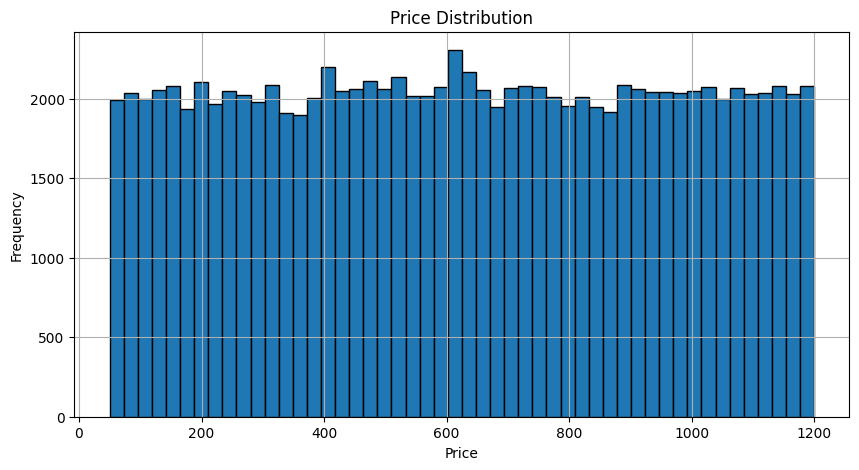


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 6

===== VISUALIZATION MENU =====
1. Price Distribution
2. Price by Room Type
3. Price by Neighborhood
4. Price vs Reviews Scatter Plot
5. Top Hosts Bar Chart
Enter your choice: 2


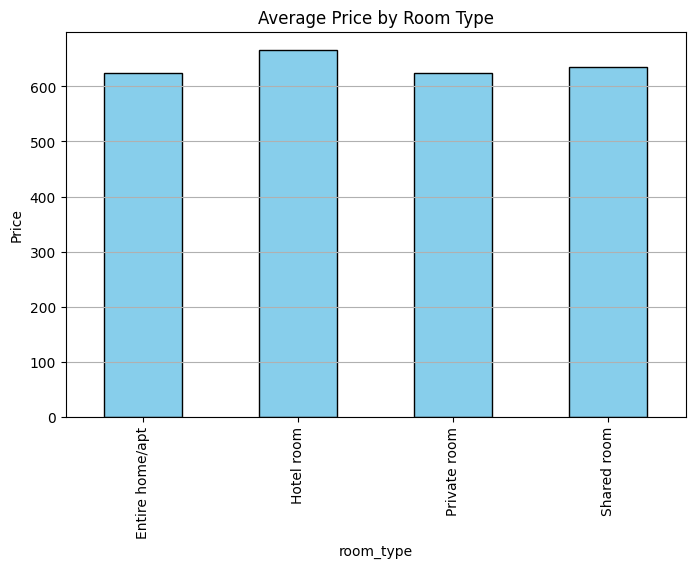


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 6

===== VISUALIZATION MENU =====
1. Price Distribution
2. Price by Room Type
3. Price by Neighborhood
4. Price vs Reviews Scatter Plot
5. Top Hosts Bar Chart
Enter your choice: 3


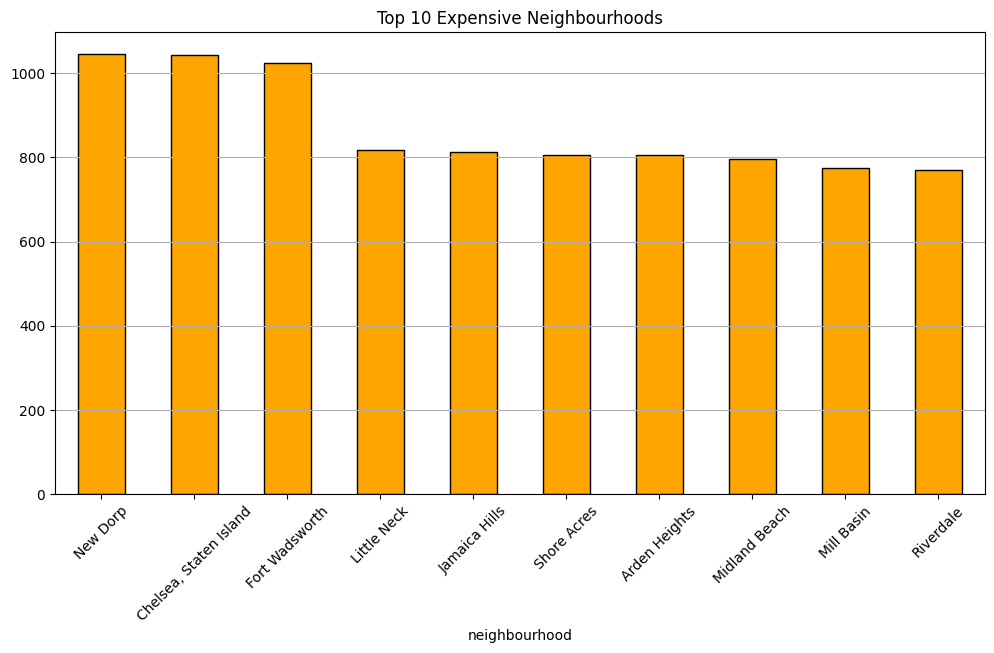


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 6

===== VISUALIZATION MENU =====
1. Price Distribution
2. Price by Room Type
3. Price by Neighborhood
4. Price vs Reviews Scatter Plot
5. Top Hosts Bar Chart
Enter your choice: 4


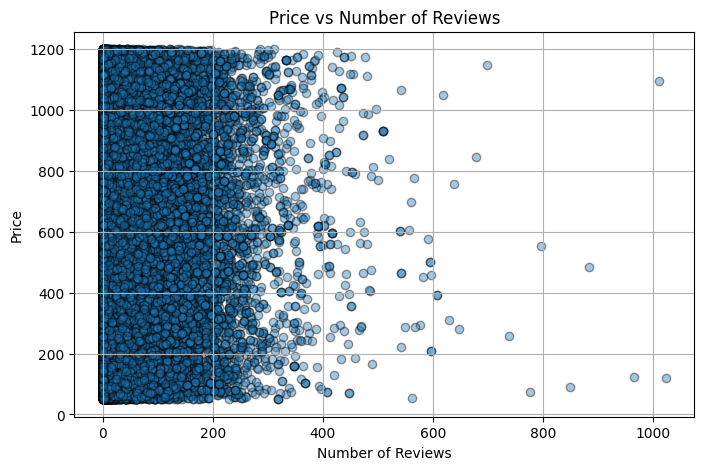


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 6

===== VISUALIZATION MENU =====
1. Price Distribution
2. Price by Room Type
3. Price by Neighborhood
4. Price vs Reviews Scatter Plot
5. Top Hosts Bar Chart
Enter your choice: 5


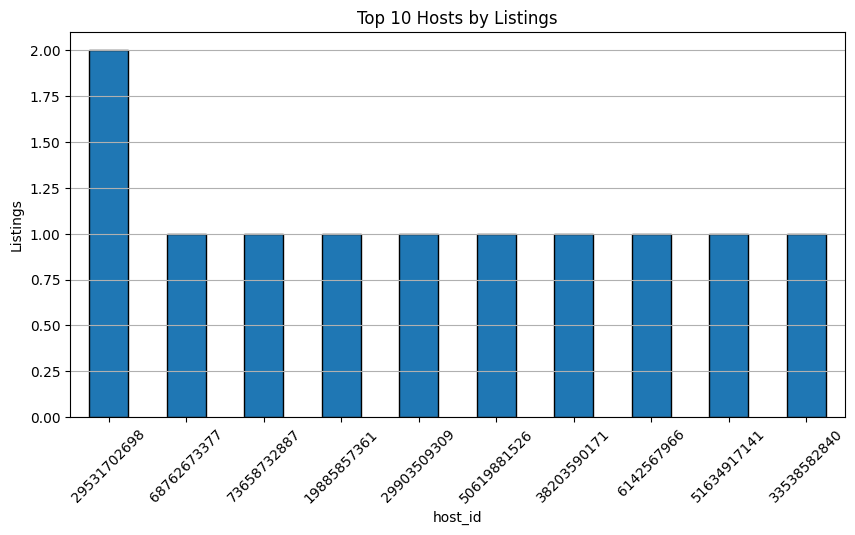


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 7

===== ADVANCED VISUALIZATIONS =====
1. Price Boxplot
2. Correlation Heatmap
3. Scatter Matrix
Enter your choice: 1


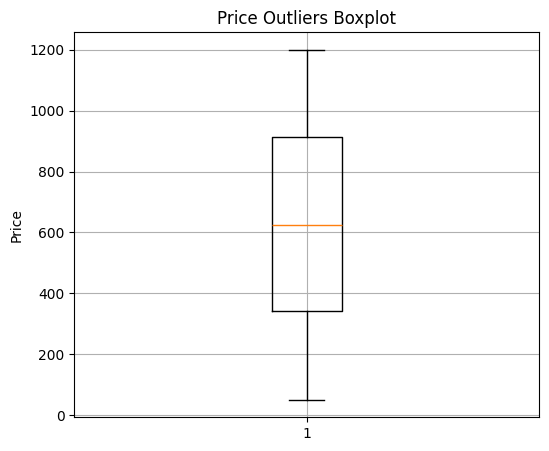


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 7

===== ADVANCED VISUALIZATIONS =====
1. Price Boxplot
2. Correlation Heatmap
3. Scatter Matrix
Enter your choice: 2


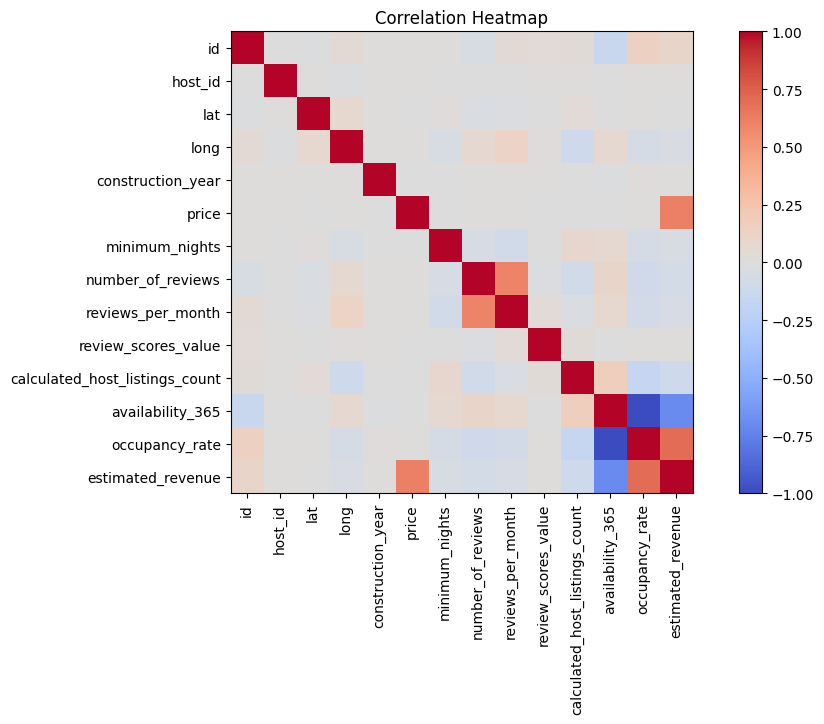


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 7

===== ADVANCED VISUALIZATIONS =====
1. Price Boxplot
2. Correlation Heatmap
3. Scatter Matrix
Enter your choice: 3


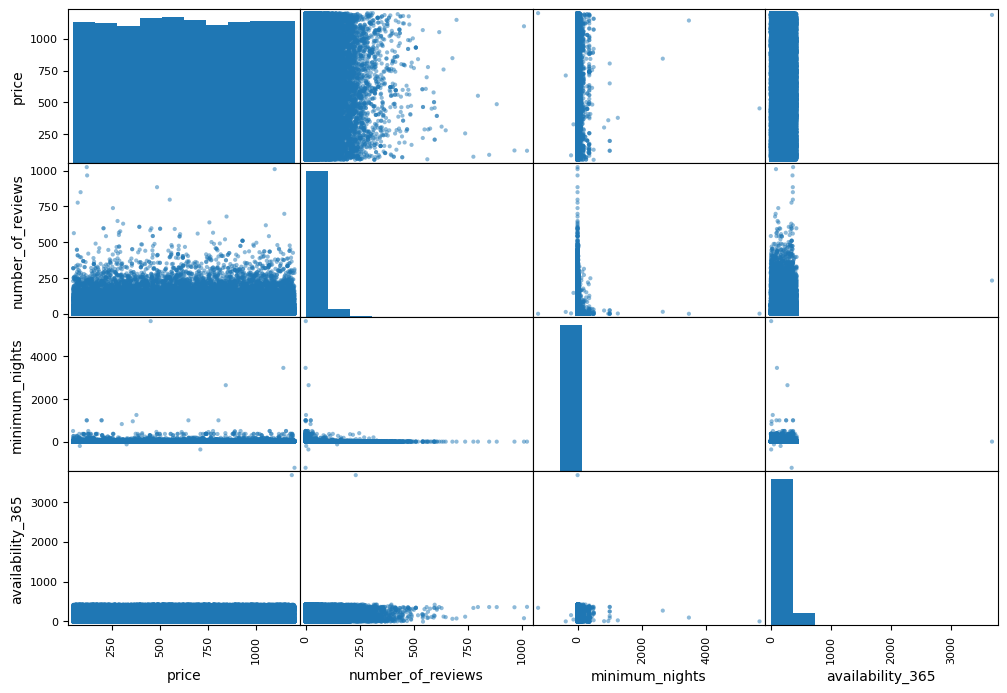


================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7. Advanced Visualizations
8. Show Price Outliers
9. Show Derived Features
0. Exit Program
Enter your choice: 8

===== PRICE OUTLIERS ====

📌 Detected 0 price outliers.
Empty DataFrame
Columns: [id, name, host_id, host_identity_verified, host_name, neighbourhood_group, neighbourhood, lat, long, country, country_code, instant_bookable, cancellation_policy, room_type, construction_year, price, service_fee, minimum_nights, number_of_reviews, last_review, reviews_per_month, review_scores_value, calculated_host_listings_count, availability_365, house_rules, license, occupancy_rate, estimated_revenue]
Index: []

[0 rows x 28 columns]

================= AIRBNB ANALYZER MENU ================
1. Basic Dataset Info
2. Show Number of Rows
3. Show Number of Columns
4. Price Analysis
5. Host Analysis
6. Visualizations
7.

In [56]:
def show_main_menu():
    while True:
        try:
            print("\n================= AIRBNB ANALYZER MENU ================")
            print("1. Basic Dataset Info")
            print("2. Show Number of Rows")
            print("3. Show Number of Columns")
            print("4. Price Analysis")
            print("5. Host Analysis")
            print("6. Visualizations")
            print("7. Advanced Visualizations")
            print("8. Show Price Outliers")
            print("9. Show Derived Features")
            print("0. Exit Program")
            print("=======================================================")
            choice = int(input("Enter your choice: "))
            return choice
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

def price_menu():
    while True:
        try:
            print("\n===== PRICE ANALYSIS MENU =====")
            print("1. Price Summary")
            print("2. Average Price by Room Type")
            print("3. Top 10 Expensive Neighborhoods")
            print("4. Most Expensive Listings")
            print("5. Correlation With Price")
            choice = int(input("Enter your choice: "))
            return choice
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

def host_menu():
    while True:
        try:
            print("\n===== HOST ANALYSIS MENU =====")
            print("1. Top Hosts")
            print("2. Host Response Rates")
            print("3. Host Acceptance Rates")
            print("4. Host Review Scores")
            print("5. Host Availability Stats")
            choice = int(input("Enter your choice: "))
            return choice
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

def visualization_menu():
    while True:
        try:
            print("\n===== VISUALIZATION MENU =====")
            print("1. Price Distribution")
            print("2. Price by Room Type")
            print("3. Price by Neighborhood")
            print("4. Price vs Reviews Scatter Plot")
            print("5. Top Hosts Bar Chart")
            choice = int(input("Enter your choice: "))
            return choice
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

def advanced_visualization_menu():
    while True:
        try:
            print("\n===== ADVANCED VISUALIZATIONS =====")
            print("1. Price Boxplot")
            print("2. Correlation Heatmap")
            print("3. Scatter Matrix")
            choice = int(input("Enter your choice: "))
            return choice
        except ValueError:
            print("❌ Invalid input. Please enter a number.")

# Load & Auto-clean dataset
loader = DataLoader("Airbnb_Open_Data.csv")

df = loader.load_data()
df = loader.standardize_column_names()
df = loader.convert_columns()
df = loader.handle_missing_values()
df = loader.remove_duplicates()
df = loader.create_derived_features()
df = loader.create_host_score()

print("\n📌 Data Loaded & Cleaned Successfully!\n")

# Create analysis & visualization objects
price = PriceAnalysis(df)
host = HostAnalysis(df)
viz  = Visualizer(df)


while True:
    choice = show_main_menu()

    # Exit
    if choice == 0:
        print("\nExiting Program... Have a nice day! 😊")
        break

    # BASIC INFO
    elif choice == 1:
        loader.show_basic_info()

    # ROW COUNT
    elif choice == 2:
        print("\nTotal Rows:", df.shape[0])

    # COLUMN COUNT
    elif choice == 3:
        print("\nTotal Columns:", df.shape[1])
        print("Column Names:", df.columns.tolist())

    # PRICE ANALYSIS
    elif choice == 4:
        p = price_menu()
        if p == 1: print(price.price_summary())
        elif p == 2: print(price.price_by_room_type())
        elif p == 3: print(price.price_by_neighbourhood())
        elif p == 4: print(price.most_expensive_listings())
        elif p == 5: print(price.correlation_with_price())
        else: print("❌ Invalid Choice")

    # HOST ANALYSIS
    elif choice == 5:
        h = host_menu()
        if h == 1: print(host.top_hosts())
        elif h == 2: print(host.host_response_rates())
        elif h == 3: print(host.host_acceptance_rates())
        elif h == 4: print(host.host_review_scores())
        elif h == 5: print(host.availability_stats())
        else: print("❌ Invalid Choice")

    # BASIC VISUALIZATIONS
    elif choice == 6:
        v = visualization_menu()
        if v == 1: viz.price_distribution()
        elif v == 2: viz.price_by_room_type()
        elif v == 3: viz.price_by_neighbourhood()
        elif v == 4: viz.price_vs_reviews()
        elif v == 5: viz.top_hosts()
        else: print("❌ Invalid Choice")

    # ADVANCED VISUALIZATIONS
    elif choice == 7:
        av = advanced_visualization_menu()
        if av == 1: viz.price_boxplot()
        elif av == 2: viz.correlation_heatmap()
        elif av == 3: viz.scatter_matrix()
        else: print("❌ Invalid Choice")

    # OUTLIERS
    elif choice == 8:
        print("\n===== PRICE OUTLIERS ====")
        print(loader.detect_price_outliers().head())

    # DERIVED FEATURES
    elif choice == 9:
        print("\n===== DERIVED FEATURES SAMPLE ====")
        # Dynamically check which columns exist before trying to display them
        display_cols = ["price", "availability_365", "occupancy_rate", "estimated_revenue"]
        if "host_score" in df.columns:
            display_cols.append("host_score")
        else:
            print("Note: 'host_score' column not available (likely due to missing prerequisite columns like 'review_scores_value', 'host_response_rate', or 'host_acceptance_rate').")

        print(df[display_cols].head())

    else:
        print("❌ Invalid Option!! Try again.")